In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [13]:
#datasets = ['autompg','bike', 'concreteslump', 'energy','houseelectric','keggdirected','parkinsons']

data = 'parkinsons'

with open('figures/{}_coverage_larger.pkl'.format(data), 'rb') as file:
    coverage = pickle.load(file)
with open('figures/{}_covlength_larger.pkl'.format(data), 'rb') as file:
    size = pickle.load(file)
with open('figures/{}_covlengthstd_larger.pkl'.format(data), 'rb') as file:
    size_std = pickle.load(file)
with open('figures/{}_quantiles_larger.pkl'.format(data), 'rb') as file:
    quantiles = pickle.load(file)

In [14]:
coverage['ncp']

array([[[0.685],
        [0.65 ],
        [0.63 ],
        [0.7  ],
        [0.705]]])

In [15]:
size['ncp']

array([[[1.76372731],
        [2.07316804],
        [1.6692847 ],
        [1.72307312],
        [2.2473731 ]]])

In [16]:
coverage['nf']

array([[[0.86 ],
        [0.82 ],
        [0.87 ],
        [0.85 ],
        [0.845]]])

In [17]:
size['nf']

array([[[0.15803222],
        [0.25624818],
        [0.26497051],
        [0.22591598],
        [0.21986136]]])

In [18]:
coverage['rfcc']

array([[[0.905],
        [0.9  ],
        [0.91 ],
        [0.875],
        [0.905]]])

In [19]:
size['rfcc']

array([[[0.08882431],
        [0.08399198],
        [0.07978323],
        [0.0774603 ],
        [0.08239711]]])

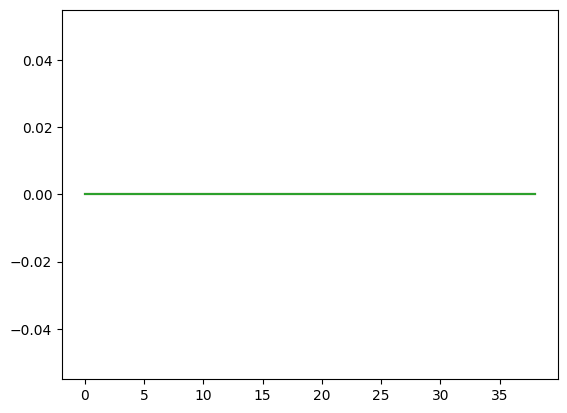

In [4]:
plt.plot(quantiles["nf"][0][0,0])

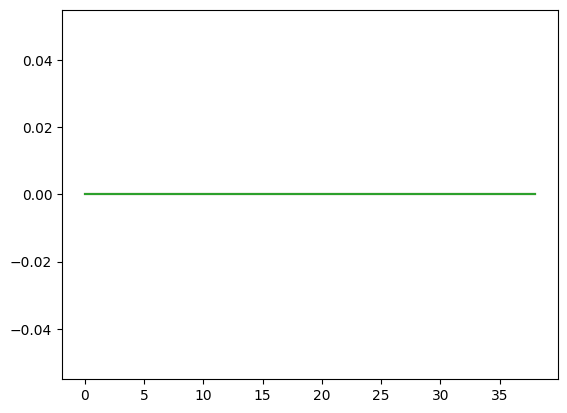

In [5]:
plt.plot(quantiles["ncp"][0][0,0])

In [22]:
from NCP.utils import frnp

import torch
from torch.optim import Adam
from NCP.model import NCPOperator, NCPModule
from NCP.nn.layers import MLP
from NCP.nn.losses import CMELoss
from NCP.nn.nf_module import NFModule
from NCP.utils import frnp, FastTensorDataLoader
import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint

from NCP.metrics import smooth_cdf
from NCP.cdf import compute_marginal
from NCP.examples.tools.lincde import lincde

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

import normflows as nf

from deel.puncc.regression import SplitCP
from uci_datasets import Dataset
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

In [23]:
xscaler = StandardScaler()
yscaler = StandardScaler()

data = Dataset('slice')

X_train, Y_train, X_test, Y_test = data.get_split(split=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)

X_train = xscaler.fit_transform(X_train)
Y_train = yscaler.fit_transform(Y_train)

X_val = xscaler.transform(X_val)
Y_val = yscaler.transform(Y_val)
X_test = xscaler.transform(X_test)
Y_test = yscaler.transform(Y_test)

X_train_torch = frnp(X_train)
Y_train_torch = frnp(Y_train)
X_val_torch = frnp(X_val)
Y_val_torch = frnp(Y_val)
X_test_torch = frnp(X_test)
Y_tes_torch = frnp(Y_test)

#y discretisation for computing cdf
spread = np.max(Y_train) - np.min(Y_train)
p1, p99 = np.min(Y_train), np.max(Y_train)
y_discr, step = np.linspace(p1-0.1*spread, p99+0.1*spread, num=5000, retstep=True)
y_discr_torch = torch.Tensor(y_discr.reshape((-1, 1)))

k_pdf = compute_marginal(bandwidth='scott').fit(Y_train)
marginal = lambda x : torch.Tensor(np.exp(k_pdf.score_samples(x.reshape(-1, 1))))

train_dl = FastTensorDataLoader(X_train_torch, Y_train_torch, batch_size=len(X_train_torch), shuffle=False)
val_dl = FastTensorDataLoader(X_val_torch, Y_val_torch, batch_size=len(X_val_torch), shuffle=False)


slice dataset, N=53500, d=385


In [46]:

def find_best_quantile(x, cdf, alpha):
    t0 = 0
    t1 = 1
    best_t0 = 0
    best_t1 = -1
    best_size = np.inf

    while t0 < len(cdf):
        # stop if left border reaches right end of discretisation
        if cdf[t1] - cdf[t0] >= 1-alpha:
            # if x[t0], x[t1] is a confidence interval at level alpha, compute length and compare to best
            size = x[t1] - x[t0]
            if size < best_size:
                best_t0 = t0
                best_t1 = t1
                best_size = size
            # moving t1 to the right will only increase the size of the interval, so we can safely move t0 to the right
            t0 += 1
        
        elif t1 == len(cdf)-1:
            # if x[t0], x[t1] is not a confidence interval with confidence at least level alpha, 
            #and t1 is already at the right limit of the discretisation, then there remains no more pertinent intervals
            break
        else:
            # if moving x[t0] to the right reduces the level, we need to increase t1
            t1 += 1
    return x[best_t0], x[best_t1]

def get_quantiles(values, cdf, alpha):
    for i, level in enumerate(cdf):
        if level >= alpha/2:
            if i == 0:
                q1 = -np.inf
            q1 = values[i-1]
            break
    else:
        q1 = np.inf
    for i, level in enumerate(cdf):
        if level >= 1-alpha/2:
            if i == 0:
                q2 = -np.inf
            q2 = values[i-1]
            break  
    # special case where we exceeded the maximum observed value
    else:
        q2 = np.inf

    return q1, q2

In [25]:
def quantile_regression(model, X, y_discr, alpha=0.01, postprocess='centering', marginal=None, model_type='NCP', how='best'):
    if model_type=='NCP':
        if len(y_discr) <= 5000:
            x, cdf = model.cdf(X, y_discr, postprocess=postprocess)
        else:
            x, pdf = model.pdf(torch.Tensor(X), y_discr, p_y=marginal, postprocess='whitening')
            ys_bis = y_discr.numpy().flatten()
            step = (ys_bis[1]-ys_bis[0])
            cdf = np.cumsum(pdf * step, -1)
        cdf = smooth_cdf(x, cdf)

    elif model_type == 'NF':
        xs = torch.Tensor(X).repeat(y_discr.size()[0], 1)
        log_prob = model.log_prob(y_discr, xs).detach().cpu().numpy()
        prob = np.exp(log_prob)
        ys_bis = y_discr.numpy().flatten()
        cdf = np.cumsum(prob)*(ys_bis[1] - ys_bis[0])
        x = y_discr.numpy().flatten()
    else:
        print('no such method', model_type)
    if how=='best':
        return find_best_quantile(x, cdf, alpha=alpha)
    else:
        return get_quantiles(x, cdf, alpha)

In [26]:
output_shape=200

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class CustomModelCheckpoint(ModelCheckpoint):
    def on_save_checkpoint(self, trainer, pl_module, checkpoint):
        X, Y = trainer.model.batch
        trainer.model.model._compute_data_statistics(X, Y)

def restore_buffers_shape(model, state_dict):
    model._sing_val = torch.zeros_like(state_dict['model._sing_val']).to('cpu')
    model._sing_vec_l = torch.zeros_like(state_dict['model._sing_vec_l']).to('cpu')
    model._sing_vec_r = torch.zeros_like(state_dict['model._sing_vec_r']).to('cpu')

MLP_kwargs_U = {
    'input_shape': X_train.shape[-1],
    'output_shape': output_shape,
    'n_hidden': 3,
    'layer_size': 128,
    'dropout': 0.,
    'iterative_whitening': False,
    'activation': torch.nn.ReLU
}

MLP_kwargs_V = {
    'input_shape': Y_train.shape[-1],
    'output_shape': output_shape,
    'n_hidden': 3,
    'layer_size':128,
    'dropout': 0,
    'iterative_whitening': False,
    'activation': torch.nn.ReLU
}

loss_fn = CMELoss
loss_kwargs = {
    'mode': 'split',
    'gamma': 2e-1}

reg = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs_U, V_operator_kwargs=MLP_kwargs_V)
optimizer_kwargs = {
        'lr': 1e-3
        }
NCP_module = NCPModule(
    reg,
    Adam,
    optimizer_kwargs,
    CMELoss,
    loss_kwargs
)

early_stop = EarlyStopping(monitor="val_loss", patience=300, mode="min")
checkpoint_callback = CustomModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min")

trainer = L.Trainer(**{
    'accelerator': device,
    'max_epochs': int(5e3),
    'log_every_n_steps': 1,
    'enable_progress_bar': True,
    'devices': 1,
    'enable_checkpointing': True,
    'num_sanity_val_steps': 0,
    'enable_model_summary': False,
    }, callbacks=[early_stop, checkpoint_callback])

trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

# recover best model during training
best_model_dict = torch.load(checkpoint_callback.best_model_path)
restore_buffers_shape(reg, best_model_dict['state_dict'])
NCP_module.load_state_dict(best_model_dict['state_dict'])
best_model = NCP_module.model


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
d:\Gregoire\anaconda3\envs\koopman\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1948: 100%|██████████| 1/1 [00:00<00:00, 12.53it/s, v_num=67, val_loss=69.00, train_loss=68.90]


In [47]:
# Test coverage on test set
quants = []
for i, xi in enumerate(tqdm(X_test[:100])):
    q = quantile_regression(best_model, np.array([xi]), y_discr_torch, alpha=0.2, postprocess='centering', marginal=marginal, how='notbest')
    quants.append(q)
quants = np.array(quants)

  8%|▊         | 8/100 [03:35<49:29, 32.28s/it]

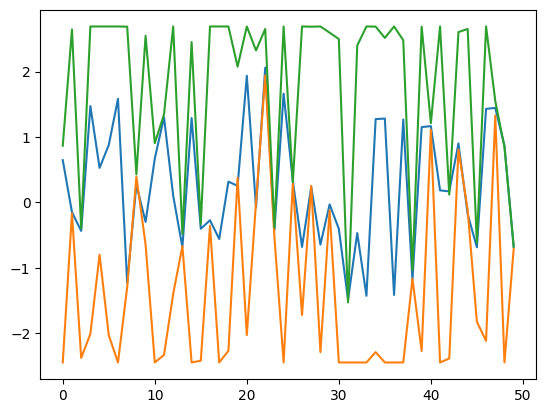

In [ ]:
plt.plot(Y_test[:50])
plt.plot(quants[:50])

In [ ]:
X_train_torch[1].repeat(1, 1)

tensor([[-1.4623e+00, -3.4030e-01, -3.6322e-01, -4.8518e-01, -6.0872e-01,
         -7.2481e-01, -7.4802e-01,  4.3401e-01,  9.7124e-01,  1.5342e-01,
         -1.8397e-01, -3.3127e-01, -3.3923e-01, -4.6722e-01, -5.4941e-01,
         -6.0465e-01, -5.4491e-01,  1.3583e+00, -1.2741e-01,  5.0261e-02,
          4.7880e-01, -3.4671e-01, -3.7405e-01, -4.5140e-01, -5.2215e-01,
         -5.1731e-01, -4.2509e-01,  1.9402e+00, -5.5248e-02,  4.2320e-02,
          3.1064e-01, -3.6473e-01, -4.2659e-01, -4.8614e-01, -5.3248e-01,
         -4.8875e-01, -3.9113e-01, -1.7767e-01,  4.4890e-01,  9.8778e-01,
         -5.0288e-01, -3.5122e-01, -4.3603e-01, -5.1677e-01, -4.8930e-01,
         -4.1604e-01, -2.3832e-01,  1.8557e-01, -5.0998e-01, -3.8740e-01,
         -1.3706e-01, -3.4677e-01, -4.1616e-01, -5.0787e-01, -5.6524e-01,
         -4.7695e-01, -1.2870e-01, -4.7247e-01, -3.0494e-01, -1.2727e-01,
          0.0000e+00, -3.5424e-01, -4.1967e-01, -5.1460e-01, -5.5698e-01,
         -4.7105e-01, -1.4332e-01, -4.

In [43]:

x, pdf = best_model.pdf(X_train_torch[1].repeat(1,1), y_discr_torch, p_y=marginal, postprocess='whitening')
step = (y_discr[1]-y_discr[0])
cdf = np.cumsum(pdf * step, -1)
cdf = smooth_cdf(x, cdf)

In [44]:
x, cdf2 = best_model.cdf(X_train_torch[1].repeat(1,1), y_discr_torch, postprocess='whitening')
#cdf2 = smooth_cdf(x, cdf2)

[-0.76889277]


(0.009121636, 0.5495079)

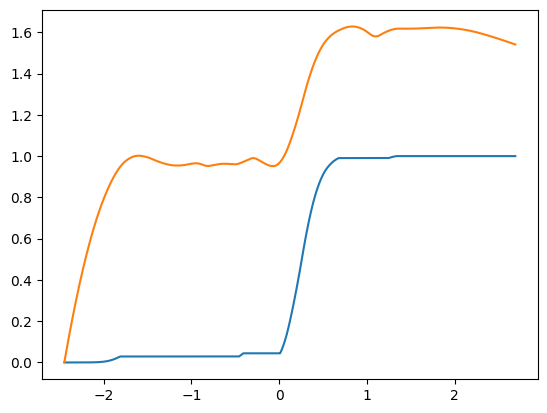

In [45]:
plt.plot(x, cdf)
plt.plot(x, cdf2)
print(Y_train[5])
find_best_quantile(x, cdf, 0.1)